In [29]:
from pymongo import MongoClient

def get_collection_date_range(collection, instId, bar):
    """
    Returns the earliest (start) and latest (end) timestamps for a specific instId and bar size
    in the specified MongoDB collection.
    
    Parameters:
    - collection: A pymongo collection object.
    - instId: The instrument ID to filter documents by.
    - bar: The bar size to filter documents by.
    
    Returns:
    - A tuple containing the start and end timestamps.
    """
    # Filter documents by instId and bar, then aggregate to find min and max timestamps
    pipeline = [
        {
            "$match": {
                "instId": instId,
                "bar": bar
            }
        },
        {
            "$group": {
                "_id": None,
                "start_date": {"$min": "$timestamp"},
                "end_date": {"$max": "$timestamp"}
            }
        }
    ]
    
    result = list(collection.aggregate(pipeline))
    
    if result:
        start_date = result[0]['start_date']
        end_date = result[0]['end_date']
        return start_date, end_date
    else:
        return None, None

# Example usage:
if __name__ == "__main__":
    client = MongoClient('mongodb://192.168.31.120:27017/')  # Adjust as needed
    db = client['crypto']  # Your database name
    collection = db['crypto_kline']  # Your collection name

    instId = "BTC-USDT"  # Example instrument ID
    bar = "1m"  # Example bar size

    start_date, end_date = get_collection_date_range(collection, instId, bar)
    if start_date and end_date:
        print(f"The earliest document for {instId} {bar} is from: {start_date}")
        print(f"The latest document for {instId} {bar} is from: {end_date}")
    else:
        print(f"No documents found in the collection for {instId} {bar}.")


The earliest document for BTC-USDT 1m is from: 2024-02-14 21:22:00
The latest document for BTC-USDT 1m is from: 2024-02-17 23:59:00


In [ ]:
from pymongo import MongoClient
import pandas as pd
import mplfinance as mpf

# MongoDB connection setup
client = MongoClient('mongodb://localhost:27017/')  # Adjust as needed
db = client['crypto_db']  # Your database name
collection = db['ETH-USDT-SWAP-1m']  # Your collection name

# Input general date
start_date_input = "20231001"  # Start of the date range, format: YYYYMMDD
end_date_input = "20231101"  # End of the date range, format: YYYYMMDD

# Convert to concrete format with time and milliseconds
start_date = pd.to_datetime(start_date_input).strftime('%Y%m%d') + "000000"
end_date = pd.to_datetime(end_date_input).strftime('%Y%m%d') + "000000"

# Query to fetch data between the specified dates
query = {"timestamp": {"$gte": start_date, "$lte": end_date}}
print(query)
projection = {"_id": 0, "timestamp": 1, "open": 1, "high": 1, "low": 1, "close": 1, "volume": 1}

# Fetch data from MongoDB
data = collection.find(query, projection)

# Convert to pandas DataFrame
df = pd.DataFrame(list(data))

display(df)



In [11]:
# Ensure data is in the correct format and sorted
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H%M%S')
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

# Plot using mplfinance
mpf.plot(df.loc[1,10000], type='candle', style='charles',
         title='ETH-USDT-SWAP 1m Data',
         ylabel='Price (USD)',
         ylabel_lower='Volume',
         volume=True,
         figratio=(12, 8),
         mav=(3,6,9))

# Show plot
mpf.show()

KeyError: 10000

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

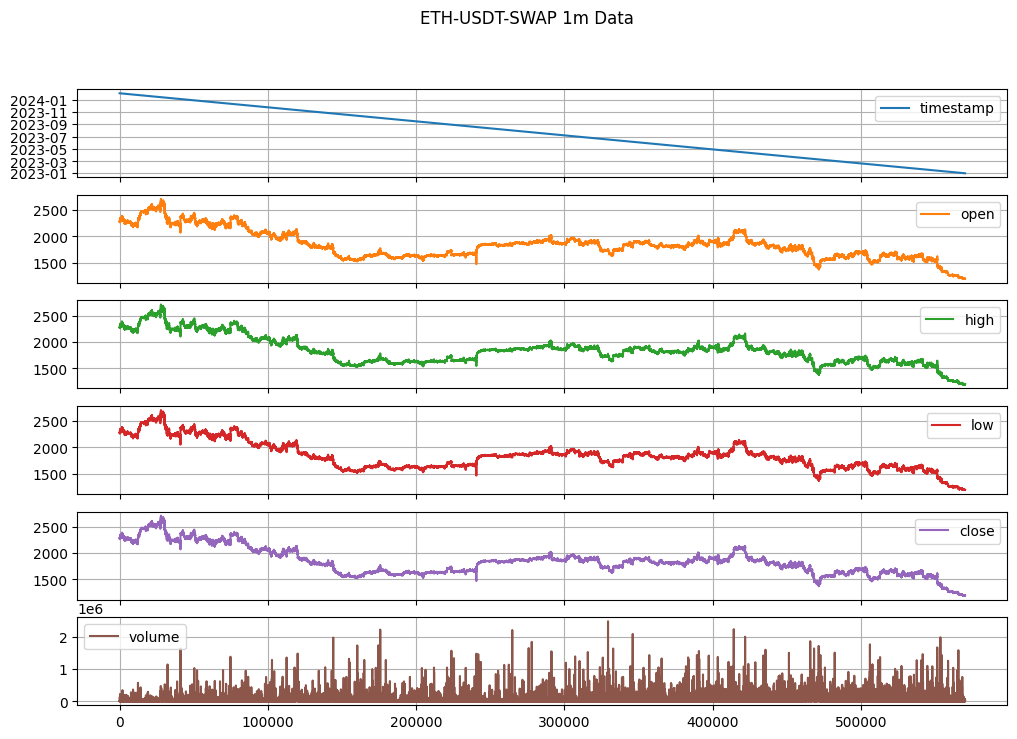

In [7]:
df.plot(figsize=(12, 8), title='ETH-USDT-SWAP 1m Data', subplots=True, grid=True)

In [ ]:
import pandas as pd

# Sample DataFrame creation (replace this with your actual DataFrame loading)
# Ensure your DataFrame's index is a DateTimeIndex and is sorted
# df = pd.DataFrame(data)

# Resample and aggregate
df_hourly = df.resample('1H').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

print(df_hourly)


In [ ]:
from pymongo import MongoClient
import pandas as pd
from datetime import timedelta

def get_latest_timestamp(collection):
    """
    Finds the latest timestamp in the MongoDB collection.
    """
    latest_doc = collection.find().sort("timestamp", -1).limit(1)
    latest_timestamp = None
    for doc in latest_doc:
        latest_timestamp = doc['timestamp']
    return latest_timestamp

def load_data_from_db(collection, start_date, end_date):
    """
    Loads data from the MongoDB collection between the specified start and end dates.
    """
    query = {"timestamp": {"$gte": start_date, "$lte": end_date}}
    projection = {"_id": 0}  # Exclude the _id field
    data = collection.find(query, projection)
    return pd.DataFrame(list(data))

# MongoDB connection setup
client = MongoClient('mongodb://localhost:27017/')  # Adjust as needed
db = client['crypto_db']  # Your database name
collection = db['ETH-USDT-SWAP-1m']  # Your collection name

# Get the latest timestamp in the collection
latest_timestamp_str = get_latest_timestamp(collection)
if latest_timestamp_str:
    # Convert the latest timestamp to a datetime object
    latest_timestamp = pd.to_datetime(latest_timestamp_str, format='%Y-%m-%d %H:%M:%S')


    # Calculate the start date as 1 month before the latest timestamp
    start_date = latest_timestamp - pd.DateOffset(months=1)

    # Convert start_date and latest_timestamp back to string if necessary for the query
    start_date_str = start_date.strftime('%Y%m%d%H%M%S')
    end_date_str = latest_timestamp.strftime('%Y%m%d%H%M%S')

    # Load data from the database between start_date and end_date
    df = load_data_from_db(collection, start_date_str, end_date_str)
    
    print(df)
else:
    print("No data found in the collection.")


In [48]:
import pandas as pd
data = collection.find(projection={"_id": 0, "timestamp": 1, "instId":1, "bar": 1, "open": 1, "high": 1, "low": 1, "close": 1, "volume": 1})
data_list = list(data)

if data_list:
    df = pd.DataFrame(data_list)
    print(df)
else:
    print("No data found for the specified date range.")


                  timestamp         open         high          low  \
0       2024-02-17 23:57:00  260593.4000  260593.4000  260593.4000   
1       2024-02-17 23:54:00  260593.4000  260593.4000  260593.4000   
2       2024-02-17 23:51:00  260593.4000  260593.4000  260593.4000   
3       2024-02-17 23:48:00  260593.4000  260593.4000  260593.4000   
4       2024-02-17 23:45:00  260593.4000  260593.4000  260593.4000   
...                     ...          ...          ...          ...   
2315242 2023-12-24 02:30:00       0.2267       0.2273       0.2250   
2315243 2023-12-24 02:00:00       0.2269       0.2272       0.2237   
2315244 2023-12-24 01:30:00       0.2232       0.2272       0.2232   
2315245 2023-12-24 01:00:00       0.2218       0.2231       0.2218   
2315246 2023-12-24 00:30:00       0.2220       0.2220       0.2218   

               close        volume   instId  bar  
0        260593.4000      0.000000  BTC-BRL   3m  
1        260593.4000      0.000000  BTC-BRL   3m  
2     

In [49]:
df.describe()

,timestamp,open,high,low,close,volume
count,2315247,2.315247e+06,2.315247e+06,2.315247e+06,2.315247e+06,2.315247e+06
mean,2023-11-19 00:57:07.952405248,1.689281e+04,1.689704e+04,1.688960e+04,1.689342e+04,8.631790e+12
min,2018-05-06 16:00:00,5.530000e-11,5.690000e-11,4.680000e-11,5.540000e-11,0.000000e+00
25%,2023-12-09 08:09:00,1.014900e-01,1.019400e-01,1.012100e-01,1.014900e-01,0.000000e+00
50%,2024-01-27 17:30:00,7.841000e-01,7.874000e-01,7.809000e-01,7.840000e-01,1.103789e+03
75%,2024-02-12 20:48:00,5.892000e+00,5.901000e+00,5.888000e+00,5.892000e+00,5.208612e+04
max,2024-02-17 23:59:00,1.630080e+06,1.630080e+06,1.629033e+06,1.630080e+06,9.799718e+17
std,NaN,1.475984e+05,1.476288e+05,1.475748e+05,1.476035e+05,1.163760e+15


In [1]:
from pymongo import MongoClient
from datetime import datetime
import pandas as pd

def get_crypto_kline(collection, instId, bar, start_date=None, end_date=None):
    """
    Fetches k-line data for a given cryptocurrency instrument from MongoDB.
    
    Parameters:
    - collection: A pymongo collection object for querying.
    - instId: The instrument ID to query for.
    - bar: The granularity of the k-line data (e.g., "1D" for daily).
    - symbol: The symbol to query for.
    - start_date: The start date for the query range (inclusive).
    - end_date: The end date for the query range (inclusive).
    
    Returns:
    - A pandas DataFrame containing the k-line data.
    """
    # Convert start_date and end_date to UNIX timestamps in milliseconds
    query_filter = {
        "instId": instId,
        "bar": bar,
    }
    
    if start_date:
        start_timestamp = int(datetime.strptime(start_date, "%Y-%m-%d").timestamp() * 1000)
        query_filter["timestamp"] = {"$gte": start_timestamp}
    
    if end_date:
        end_timestamp = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp() * 1000)
        if "timestamp" in query_filter:
            query_filter["timestamp"]["$lte"] = end_timestamp
        else:
            query_filter["timestamp"] = {"$lte": end_timestamp}
    
    # Perform the query
    cursor = collection.find(query_filter, {'_id': 0})
    # Convert the cursor to a pandas DataFrame
    df = pd.DataFrame(list(cursor))
    
    # Convert timestamps back to readable dates if necessary
    if not df.empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    return df

# Example usage
if __name__ == "__main__":
    client = MongoClient('mongodb://192.168.31.120:27017/')
    db = client['crypto']  # Adjust as per your MongoDB setup
    collection = db['crypto_kline']  # Adjust as per your MongoDB setup
    
    instId = "BTC-USDT"
    bar = "1m"
    # start_date = "2021-01-01"
    # end_date = "2021-12-31"
    
    df = get_crypto_kline(collection, instId, bar,)
    print(df)


               timestamp     open     high      low    close     volume  \
0    2024-02-17 23:59:00  51645.9  51646.0  51645.9  51646.0   0.627526   
1    2024-02-17 23:58:00  51636.0  51646.0  51629.6  51646.0   1.076311   
2    2024-02-17 23:57:00  51661.8  51661.8  51636.1  51636.1   3.898531   
3    2024-02-17 23:56:00  51663.6  51663.6  51661.7  51661.7   0.401098   
4    2024-02-17 23:55:00  51679.2  51679.2  51663.6  51663.7   0.575550   
...                  ...      ...      ...      ...      ...        ...   
2295 2024-02-14 21:26:00  51509.6  51521.9  51509.5  51521.1   1.864613   
2296 2024-02-14 21:25:00  51492.0  51515.5  51492.0  51509.6   2.577159   
2297 2024-02-14 21:24:00  51503.2  51503.2  51485.0  51492.0   1.683550   
2298 2024-02-14 21:23:00  51526.2  51526.2  51492.1  51503.2  11.079557   
2299 2024-02-14 21:22:00  51503.5  51528.7  51501.9  51526.2   1.540728   

             volCcy    volCcyQuote confirm    instId bar  
0      32409.168043   32409.168043      

In [2]:
import pandas as pd
import mplfinance as mpf

df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)



In [24]:
import os
import shutil
# If existing, remove it by force
if os.path.exists('./output'):
    shutil.rmtree('./output')
os.mkdir('./output')
# Plotting the K-line chart
i = 0
while i < len(df):
    savefig_options = {
    'fname': f'./output/high_res_plot_{i}.png',  # Filename to save the plot
    'dpi': 300,  # Increase DPI for higher resolution
    'pad_inches': 0.25  # Optional: Padding around the figure
}
    mpf.plot(df[i:i+100], type='candle', style='charles',
            title=f'Crypto K-Line Chart:{df[i:i+100].iloc[0].instId}-{df[i:i+100].iloc[0].bar}',
            ylabel='Price', volume = True, mav=(7,12),savefig=savefig_options)
    i += 100

In [3]:
import finplot as fplt
# Create a candlestick chart
ax,ax2 = fplt.create_plot('AAPL Candlestick Chart', rows=2)
fplt.candlestick_ochl(df[['timestamp', 'open', 'close', 'high', 'low']], ax=ax)
fplt.volume_ocv(df[['timestamp', 'open', 'close', 'volume']], ax=ax2)

# Show the plot
fplt.show()

: 